In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import os
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import math
import warnings
from matplotlib import rcParams

import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow import keras
from tensorflow.python.keras.layers import Dropout, Dense, LSTM,Activation,GRU,SimpleRNN
from tensorflow.python.keras import backend as K

from keras import regularizers
from keras.losses import mean_squared_error

warnings.filterwarnings("ignore")

In [26]:
data_init = pd.read_excel("shujuji.xlsx")

x,y = data_init.iloc[:,1:6],data_init.iloc[:,-1]

In [27]:
data_init

,id,temperature,flow,PH,data_in_COD,NH3_N,total_nitrogen,data_out_COD
0,1,33.9,379.4386,5.67,362.0491,15.80,7.32,22.1080
1,2,44.4,374.3369,5.03,233.2150,21.45,12.93,44.0340
2,3,40.2,290.7272,7.11,353.9716,19.25,10.85,39.5237
3,4,44.3,388.9247,6.56,332.8261,10.97,11.61,21.0939
4,5,38.2,305.0809,5.75,391.5420,17.29,14.84,47.0766
...,...,...,...,...,...,...,...,...
255,256,27.6,301.4990,5.52,313.3165,24.55,12.90,28.0662
256,257,34.3,218.0500,5.04,275.7860,21.77,10.15,27.1045
257,258,24.1,245.5469,7.47,363.2505,22.09,11.10,33.5931
258,259,48.7,233.4377,6.17,309.1838,20.07,10.54,41.9565


In [28]:
data_init.iloc[:,1:].agg(['min','max', "mean"])

,temperature,flow,PH,data_in_COD,NH3_N,total_nitrogen,data_out_COD
min,18.000,200.711800,5.000000,200.655600,8.260000,5.0400,20.224100
max,53.000,499.845400,8.000000,399.979200,29.870000,15.0000,49.977700
mean,35.585,342.732885,6.559346,301.495241,19.055923,9.8895,34.820523


In [29]:
data_init.iloc[:,1:-1]

,temperature,flow,PH,data_in_COD,NH3_N,total_nitrogen
0,33.9,379.4386,5.67,362.0491,15.80,7.32
1,44.4,374.3369,5.03,233.2150,21.45,12.93
2,40.2,290.7272,7.11,353.9716,19.25,10.85
3,44.3,388.9247,6.56,332.8261,10.97,11.61
4,38.2,305.0809,5.75,391.5420,17.29,14.84
...,...,...,...,...,...,...
255,27.6,301.4990,5.52,313.3165,24.55,12.90
256,34.3,218.0500,5.04,275.7860,21.77,10.15
257,24.1,245.5469,7.47,363.2505,22.09,11.10
258,48.7,233.4377,6.17,309.1838,20.07,10.54


In [30]:
# 数据归一化
scaler_input = MinMaxScaler(feature_range=(0, 1))

scaler_output = MinMaxScaler(feature_range=(0, 1))

data_input = data_init.iloc[:,1:-1]
data_output = np.array(data_init.iloc[:,-1]).reshape(-1, 1)


x_data = scaler_input.fit_transform(data_input) # 数据归一化[0,1]
y_data = scaler_output.fit_transform(data_output) # 数据归一化[0,1]




In [31]:
time_steps = 4

In [32]:
xx_data = []
yy_data = []

# 测试集：csv表格中前187条数据
# 利用for循环，遍历整个训练集，提取训练集中连续5条数据作为输入特征x_train，第6条的数据作为标签
for i in range(time_steps, len(x_data)):
    xx_data.append(x_data[i - time_steps:i, :].tolist())
    yy_data.append(y_data[i])
    
yy_data = np.array(yy_data)

In [33]:
np.array(xx_data).shape

(256, 4, 6)

In [69]:
print(data_input)
print(x_data)
print(xx_data)

     temperature      flow    PH  data_in_COD  NH3_N  total_nitrogen
0           33.9  379.4386  5.67     362.0491  15.80            7.32
1           44.4  374.3369  5.03     233.2150  21.45           12.93
2           40.2  290.7272  7.11     353.9716  19.25           10.85
3           44.3  388.9247  6.56     332.8261  10.97           11.61
4           38.2  305.0809  5.75     391.5420  17.29           14.84
..           ...       ...   ...          ...    ...             ...
255         27.6  301.4990  5.52     313.3165  24.55           12.90
256         34.3  218.0500  5.04     275.7860  21.77           10.15
257         24.1  245.5469  7.47     363.2505  22.09           11.10
258         48.7  233.4377  6.17     309.1838  20.07           10.54
259         47.7  371.1947  5.11     322.3266  20.24            9.65

[260 rows x 6 columns]
[[0.45428571 0.59748153 0.22333333 0.80970593 0.34891254 0.22891566]
 [0.75428571 0.58042661 0.01       0.16334945 0.61036557 0.79216867]
 [0.634285

In [34]:
## SVR
xxx_data = []
for data in xx_data:
    model_data = []
    # 分离子浓度计算，共5个
    for k in range(5):
        model_data_include = 0
        for j in range(time_steps):
            # 距离越近，权重越高，分别是0.1-0.2-0.3-0.4
            model_data_include += 0.1*(j+1)*data[j][k]
        model_data.append(model_data_include)
    xxx_data.append(model_data)
    

In [35]:

rmse = 0

train_X, train_y = np.array(xxx_data)[:184], yy_data[:184]
test_X, test_y = np.array(xxx_data)[184:], yy_data[184:]

train_X_nn, train_y_nn = np.array(xx_data)[:184,:], yy_data[:184]
test_X_nn, test_y_nn = np.array(xx_data)[184:,:], yy_data[184:]


In [36]:
x_train,y_train = np.array(train_X_nn),np.array(train_y_nn)

In [37]:
x_train.shape,y_train.shape

((184, 4, 6), (184, 1))

In [38]:
x_test,y_test = np.array(test_X_nn),np.array(test_y_nn)
x_test.shape,y_test.shape

((72, 4, 6), (72, 1))

In [1]:
def show_data(test_y,predict_y,title):
    plt.figure(figsize=(10,8),dpi=100)
    x = [i for i in range(test_y.shape[0])]
    plt.plot(x, test_y, color='navy',lw = 2, label='Actual data')
    plt.plot(x, predict_y, color='c',lw = 2, label='Predict data')
    x_label = [i for i in x[::5]]
    
    y_label = [j for j in range(0,60,5)]
    plt.yticks(y_label)
    plt.xticks(x_label)
    plt.xlabel('Time/d')
    plt.ylabel('COD')
    plt.title(title)
    plt.legend()
    plt.show()

# LSTM

In [43]:
model_LSTM = tf.keras.Sequential([
    LSTM(128,input_shape=(x_train.shape[1], x_train.shape[2]),return_sequences=True),
     Dropout(0.5),
     LSTM(128,return_sequences=True),
     Dropout(0.2),
    LSTM(128),   
    Dropout(0.2),
    Dense(units=1,activation = 'sigmoid')
])

opt_LSTM = tf.keras.optimizers.Adam(lr=0.02)
rmse = tf.keras.metrics.RootMeanSquaredError(name='rmse')

model_LSTM.compile(optimizer=opt_LSTM,
              loss= 'mse',metrics=['mae',rmse,'mse'])

#训练
history_LSTM = model_LSTM.fit(x_train, y_train, batch_size=128, epochs=150, validation_data=(x_test, y_test), validation_freq=1)


model_LSTM.summary() #打印


Epoch 1/150
2/2 [==============================] - 9s 1s/step - loss: 0.0820 - mae: 0.2476 - rmse: 0.2863 - mse: 0.0820 - val_loss: 0.0858 - val_mae: 0.2516 - val_rmse: 0.2930 - val_mse: 0.0858
Epoch 2/150
2/2 [==============================] - 0s 50ms/step - loss: 0.0825 - mae: 0.2429 - rmse: 0.2872 - mse: 0.0825 - val_loss: 0.0805 - val_mae: 0.2458 - val_rmse: 0.2837 - val_mse: 0.0805
Epoch 3/150
2/2 [==============================] - 0s 50ms/step - loss: 0.0743 - mae: 0.2334 - rmse: 0.2726 - mse: 0.0743 - val_loss: 0.0824 - val_mae: 0.2506 - val_rmse: 0.2870 - val_mse: 0.0824
Epoch 4/150
2/2 [==============================] - 0s 51ms/step - loss: 0.0738 - mae: 0.2326 - rmse: 0.2716 - mse: 0.0738 - val_loss: 0.0813 - val_mae: 0.2491 - val_rmse: 0.2851 - val_mse: 0.0813
Epoch 5/150
2/2 [==============================] - 0s 51ms/step - loss: 0.0742 - mae: 0.2329 - rmse: 0.2724 - mse: 0.0742 - val_loss: 0.0810 - val_mae: 0.2482 - val_rmse: 0.2845 - val_mse: 0.0810
Epoch 6/150
2/2 [=====

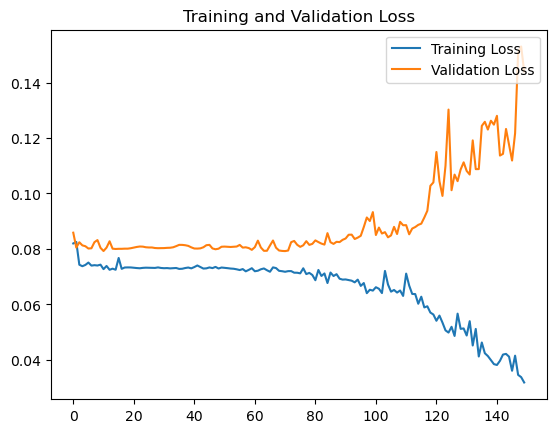

In [44]:
loss_LSTM = history_LSTM.history['loss']
val_loss_LSTM = history_LSTM.history['val_loss']

plt.plot(loss_LSTM, label='Training Loss')
plt.plot(val_loss_LSTM, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc=1)
plt.show()#展示

In [45]:
y_test1 = scaler_output.inverse_transform(y_test)

In [46]:
y_predict_LSTM = scaler_output.inverse_transform(model_LSTM.predict(x_test))

3/3 [==============================] - 1s 5ms/step


In [47]:
# 误差分析
rmse = math.sqrt(metrics.mean_squared_error(y_test1, y_predict_LSTM)) 

mae=np.sum(np.absolute(y_predict_LSTM-y_test1))/len(y_test1)
mae2=np.mean(np.absolute(y_predict_LSTM-y_test1))

mape = np.mean(np.abs((y_test1-y_predict_LSTM) / y_test1)) * 100
mape2 = np.sum(np.abs((y_predict_LSTM - y_test1) / y_test1)) * 100/len(y_test1)

print("rmse:",rmse,"mae:",mae,"mae2:",mae2,"mape:",mape,"mape2:",mape2)

rmse: 11.291042008909194 mae: 9.500439168421428 mae2: 9.500439168421428 mape: 31.305646219727112 mape2: 31.30564621972711


In [2]:
show_data(y_test1,y_predict_LSTM,"LSTM")

NameError: name 'y_test1' is not defined

In [49]:
data = {"real_cod": [index[0] for index in y_test1.tolist()], "predicted_cod": [index[0] for index in y_predict_LSTM.tolist()]}
print(data)
frame = pd.DataFrame(data)
frame.to_csv("LSTM_data.csv", index = False)

{'real_cod': [25.5872, 49.7674, 49.1354, 45.7133, 23.8893, 38.4926, 25.3508, 42.8149, 21.8228, 24.1469, 43.9699, 26.6769, 21.1781, 45.7951, 39.8176, 45.6353, 37.8993, 43.0188, 28.2014, 43.3048, 41.3138, 43.2491, 22.3307, 23.3522, 27.3195, 32.3059, 27.322, 22.6818, 21.4972, 38.1243, 35.8833, 44.6618, 33.2272, 35.1209, 39.3255, 40.3839, 31.690899999999996, 30.3252, 48.764, 29.7371, 34.2237, 25.9877, 47.9309, 39.931, 37.5022, 41.3256, 20.2241, 29.6502, 48.264, 38.0447, 30.0919, 25.4234, 22.1134, 28.9857, 34.8451, 43.6294, 25.3052, 33.8639, 33.2145, 34.4399, 43.5968, 34.937, 31.047900000000002, 29.0264, 29.4125, 41.7376, 21.7104, 28.0662, 27.1045, 33.5931, 41.9565, 44.5185], 'predicted_cod': [34.41505432128906, 25.81096839904785, 36.39388656616211, 38.657958984375, 37.14015579223633, 36.42805099487305, 36.171451568603516, 35.534263610839844, 37.52278518676758, 38.709922790527344, 27.891624450683594, 33.98820114135742, 38.516151428222656, 25.423192977905273, 35.666446685791016, 27.609176635